In [2]:
import numpy as np
import scipy
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import pandas as pd
import sklearn
from sklearn.linear_model import LassoCV, HuberRegressor, LinearRegression, LogisticRegression
from tqdm import tqdm
import statsmodels.api as sma
import dowhy
import econml
from econml.metalearners import TLearner
from econml.metalearners import SLearner
from econml.dr import DRLearner
from lightgbm import LGBMRegressor
from IPython.display import Image, display
jpn_fonts=list(np.sort([ttf for ttf in fm.findSystemFonts() if 'msgothic' in ttf]))
jpn_font=jpn_fonts[0]
prop = fm.FontProperties(fname=jpn_font)
sns.set()

df_cps1 = pd.read_stata('https://users.nber.org/~rdehejia/data/cps_controls.dta')
df_nsw = pd.read_stata('https://users.nber.org/~rdehejia/data/nsw_dw.dta')
display(df_cps1.head())
display(df_nsw.head())

,data_id,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,CPS1,0.0,45.0,11.0,0.0,0.0,1.0,1.0,21516.669922,25243.550781,25564.669922
1,CPS1,0.0,21.0,14.0,0.0,0.0,0.0,0.0,3175.970947,5852.564941,13496.080078
2,CPS1,0.0,38.0,12.0,0.0,0.0,1.0,0.0,23039.019531,25130.759766,25564.669922
3,CPS1,0.0,48.0,6.0,0.0,0.0,1.0,1.0,24994.369141,25243.550781,25564.669922
4,CPS1,0.0,18.0,8.0,0.0,0.0,1.0,1.0,1669.295044,10727.610352,9860.869141


,data_id,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,Dehejia-Wahba Sample,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,9930.045898
1,Dehejia-Wahba Sample,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0,3595.894043
2,Dehejia-Wahba Sample,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,24909.449219
3,Dehejia-Wahba Sample,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,7506.145996
4,Dehejia-Wahba Sample,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,289.789886


In [4]:
# df_nswの対照群をdf_cps1に入れ替える
tr_col = 'treat'  # 介入変数
target_col = 're78'  # 目的変数
all_col = ['age','education','black','hispanic','married','nodegree','re74','re75','re78']
exp_col = ['age','education','black','hispanic','married','nodegree','re74','re75'] # 共変量
num_col = ['age','education','re74','re75']
cat_col = ['black','hispanic','married','nodegree']
df_nswcps1 = pd.concat([df_nsw[df_nsw[tr_col] == 1], df_cps1], ignore_index=False).reset_index(drop=True)
display(df_nswcps1)
display(df_nswcps1.treat.value_counts().reset_index())

,data_id,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,Dehejia-Wahba Sample,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.000000,0.000000,9930.045898
1,Dehejia-Wahba Sample,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.000000,0.000000,3595.894043
2,Dehejia-Wahba Sample,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.000000,0.000000,24909.449219
3,Dehejia-Wahba Sample,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.000000,0.000000,7506.145996
4,Dehejia-Wahba Sample,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.000000,0.000000,289.789886
...,...,...,...,...,...,...,...,...,...,...,...
16172,CPS1,0.0,22.0,12.0,1.0,0.0,0.0,0.0,3975.352051,6801.435059,2757.437988
16173,CPS1,0.0,20.0,12.0,1.0,0.0,1.0,0.0,1445.938965,11832.240234,6895.071777
16174,CPS1,0.0,37.0,12.0,0.0,0.0,0.0,0.0,1733.951050,1559.370972,4221.865234
16175,CPS1,0.0,47.0,9.0,0.0,0.0,1.0,1.0,16914.349609,11384.660156,13671.929688


,index,treat
0,0.0,15992
1,1.0,185


In [5]:
### 本来の効果を回帰分析で求める ###
lalonde = df_nsw.drop(columns=['data_id']).copy()  # idを抜いたデータフレーム
lalonde[tr_col] = lalonde[tr_col].astype(bool)  # dowhyでは2値の介入変数はbool型に変換する
# モデルの定義(回帰モデル)
model=dowhy.CausalModel(data = lalonde  # データフレーム
                        , treatment='treat'  # 介入変数カラム名
                        , outcome='re78'  # 目的変数カラム名
                        , common_causes='nodegree+black+hispanic+age+education+married'.split('+')  # 共変量
                       )
# 因果効果を推定
identified_estimand = model.identify_effect()
estimate = model.estimate_effect(identified_estimand
                                 , method_name='backdoor.linear_regression'
                                 , test_significance=True
                                 , confidence_intervals=True
                                )
print(estimate)
print('Causal Estimate is ' + str(estimate.value))
print('Confidence Intervals', estimate.get_confidence_intervals())
print('p-value', estimate.test_stat_significance())

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                           
────────(E[re78|married,nodegree,hispanic,age,black,education])
d[treat]                                                       
Estimand assumption 1, Unconfoundedness: If U→{treat} and U→re78 then P(re78|treat,married,nodegree,hispanic,age,black,education,U) = P(re78|treat,married,nodegree,hispanic,age,black,education)

## Realized estimand
b: re78~treat+married+nodegree+hispanic+age+black+education
Target units: ate

## Estimate
Mean value: 1671.130415787501

Causal Estimate is 1671.130415787501
Confidence Intervals [[ 417.25402062 2925.00681095]]
p-value {'p_value': array([0.00911388])}


In [6]:
### 因果推論用のdf作成 ###
X_train = df_nswcps1[exp_col].copy()  # 共変量
y_train = df_nswcps1[tr_col].copy()  # 介入変数
target = df_nswcps1[target_col].copy()  # 目的変数
# 共変量の標準化
sc = sklearn.preprocessing.StandardScaler()  # 標準化
X_train_std = pd.DataFrame(sc.fit_transform(X_train), columns=exp_col)  # 標準化
target_std = target.copy()
display(X_train_std)  # 標準化共変量
dataset_init = pd.concat([X_train_std, target_std, y_train], axis=1)
dataset_init[tr_col] = dataset_init[tr_col].astype(bool)
display(dataset_init)  # 作成したデータフレーム

,age,education,black,hispanic,married,nodegree,re74,re75
0,0.349713,-0.351574,3.338397,-0.278318,0.645695,1.525527,-1.443954,-1.450911
1,-1.009454,-1.048944,-0.299545,3.593009,-1.548719,1.525527,-1.443954,-1.450911
2,-0.284565,-0.002888,3.338397,-0.278318,-1.548719,-0.655511,-1.443954,-1.450911
3,-0.556399,-0.351574,3.338397,-0.278318,-1.548719,1.525527,-1.443954,-1.450911
4,-0.012732,-1.397629,3.338397,-0.278318,-1.548719,1.525527,-1.443954,-1.450911
...,...,...,...,...,...,...,...,...
16172,-1.009454,-0.002888,3.338397,-0.278318,-1.548719,-0.655511,-1.030407,-0.720588
16173,-1.190677,-0.002888,3.338397,-0.278318,0.645695,-0.655511,-1.293536,-0.180392
16174,0.349713,-0.002888,-0.299545,-0.278318,-1.548719,-0.655511,-1.263575,-1.283469
16175,1.255825,-1.048944,-0.299545,-0.278318,0.645695,1.525527,0.315608,-0.228452


,age,education,black,hispanic,married,nodegree,re74,re75,re78,treat
0,0.349713,-0.351574,3.338397,-0.278318,0.645695,1.525527,-1.443954,-1.450911,9930.045898,True
1,-1.009454,-1.048944,-0.299545,3.593009,-1.548719,1.525527,-1.443954,-1.450911,3595.894043,True
2,-0.284565,-0.002888,3.338397,-0.278318,-1.548719,-0.655511,-1.443954,-1.450911,24909.449219,True
3,-0.556399,-0.351574,3.338397,-0.278318,-1.548719,1.525527,-1.443954,-1.450911,7506.145996,True
4,-0.012732,-1.397629,3.338397,-0.278318,-1.548719,1.525527,-1.443954,-1.450911,289.789886,True
...,...,...,...,...,...,...,...,...,...,...
16172,-1.009454,-0.002888,3.338397,-0.278318,-1.548719,-0.655511,-1.030407,-0.720588,2757.437988,False
16173,-1.190677,-0.002888,3.338397,-0.278318,0.645695,-0.655511,-1.293536,-0.180392,6895.071777,False
16174,0.349713,-0.002888,-0.299545,-0.278318,-1.548719,-0.655511,-1.263575,-1.283469,4221.865234,False
16175,1.255825,-1.048944,-0.299545,-0.278318,0.645695,1.525527,0.315608,-0.228452,13671.929688,False


In [7]:
# 介入変数、目的変数、共変量のDAG
causal_graph = \
"""
digraph {
age[label="Age"];
education[label="Education"];
black[label="Black"];
hispanic[label="Hispanic"];
married[label="Married"];
nodegree[label="No degree"];
re74[label="re74"];
re75[label="re75"];
re78[label="re78_target"];
treat[label="treat"];
age -> {treat re78};
education -> {treat re78};
black -> {treat re78};
hispanic -> {treat re78};
married -> {treat re78};
nodegree -> {treat re78};
re74 -> {treat re78};
re75 -> {treat re78};
treat -> re78;
}
"""

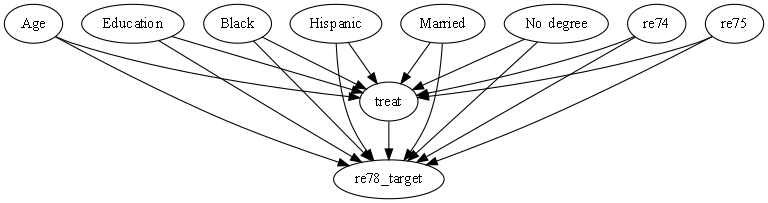

In [8]:
# データ
dataset = dataset_init.copy()
#display(dataset.head(1))
# DAGをもとにモデル定義
model= dowhy.CausalModel(data = dataset
                         , graph=causal_graph.replace("\n", " ")
                         , treatment=tr_col
                         , outcome=target_col)
# DAG可視化
model.view_model()#layout='patchwork'
display(Image(filename="causal_model.png"))

In [9]:
### バイアスがある場合の回帰分析の結果 ###
# データ
dataset = dataset_init.copy()
# DAGをもとにモデル定義
model= dowhy.CausalModel(data = dataset
                         , graph=causal_graph.replace("\n", " ")
                         , treatment=tr_col
                         , outcome=target_col)
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
# 回帰分析
causal_estimate_linear_ate = model.estimate_effect(identified_estimand
                                                   , method_name="backdoor.linear_regression"
                                                   #, target_units="ate"
                                                   , test_significance=True
                                                   , confidence_intervals=True
                                                  )
print(causal_estimate_linear_ate)
print("Causal Estimate is " + str(causal_estimate_linear_ate.value))
print('Confidence Intervals', causal_estimate_linear_ate.get_confidence_intervals())
print('p-value', causal_estimate_linear_ate.test_stat_significance())

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                     
────────(E[re78|married,nodegree,re75,hispanic,re74,age,black,education])
d[treat]                                                                 
Estimand assumption 1, Unconfoundedness: If U→{treat} and U→re78 then P(re78|treat,married,nodegree,re75,hispanic,re74,age,black,education,U) = P(re78|treat,married,nodegree,re75,hispanic,re74,age,black,education)

## Realized estimand
b: re78~treat+married+nodegree+re75+hispanic+re74+age+black+education
Target units: ate

## Estimate
Mean value: 699.1317918697696

Causal Estimate is 699.1317918697696
Confidence Intervals [[-374.29552064 1772.55910438]]
p-value {'p_value': array([0.2017492])}


In [10]:
### 傾向スコアマッチング ###
# データ
dataset = dataset_init.copy()
# DAGをもとにモデル定義
model= dowhy.CausalModel(data = dataset
                         , graph=causal_graph.replace("\n", " ")
                         , treatment=tr_col
                         , outcome=target_col)
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
# 傾向スコアのためのモデル
lr = LogisticRegression(max_iter=10000, C=500) # ロジスティック回帰
# 傾向スコアマッチング
p_score_matching_att = model.estimate_effect(identified_estimand
                                             , method_name="backdoor.propensity_score_matching"  # 傾向スコアマッチング指定
                                             , target_units='att'  # ATTを推定
                                             , method_params={'propensity_score_model':lr}  # 傾向スコアのためのモデル
                                             #, confidence_intervals=True  # 時間かかる
                                            )

#print('Causal Estimate is ' + str(p_score_matching_att.value))
#print('Confidence Intervals', p_score_matching_att.get_confidence_intervals())
#print('p-value', p_score_matching_att.test_stat_significance())
print(p_score_matching_att)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                     
────────(E[re78|married,nodegree,re75,hispanic,re74,age,black,education])
d[treat]                                                                 
Estimand assumption 1, Unconfoundedness: If U→{treat} and U→re78 then P(re78|treat,married,nodegree,re75,hispanic,re74,age,black,education,U) = P(re78|treat,married,nodegree,re75,hispanic,re74,age,black,education)

## Realized estimand
b: re78~treat+married+nodegree+re75+hispanic+re74+age+black+education
Target units: att

## Estimate
Mean value: 1493.6935249122414



In [9]:
# num_strata - データを層別化するビンの数．デフォルトは自動的に決定されます．
# clipping_threshold - 層ごとの処置または対照単位の最小数．初期値=10
# distance_metric - 使用する距離メトリック。デフォルトは "minkowski "で、p=2のユークリッド距離計に対応します。

# ITE求められないからCATE求める
# ある共変量の時のATE=CATE(各サンプルが持っている共変量のATE=CATE≒ITE)
# https://saltcooky.hatenablog.com/entry/2020/08/16/003950

In [11]:
# データ
dataset = dataset_init.copy()
# DAGをもとにモデル定義
model= dowhy.CausalModel(data = dataset
                         , graph=causal_graph.replace("\n", " ")
                         , treatment=tr_col
                         , outcome=target_col)
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
causal_estimate_dmatch_att = model.estimate_effect(identified_estimand
                                                   , method_name="backdoor.distance_matching"
                                                   , target_units="att"
                                                   , method_params={'distance_metric':"minkowski"}
                                                  )
print(causal_estimate_dmatch_att)
print("Causal Estimate is " + str(causal_estimate_dmatch_att.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                     
────────(E[re78|married,nodegree,re75,hispanic,re74,age,black,education])
d[treat]                                                                 
Estimand assumption 1, Unconfoundedness: If U→{treat} and U→re78 then P(re78|treat,married,nodegree,re75,hispanic,re74,age,black,education,U) = P(re78|treat,married,nodegree,re75,hispanic,re74,age,black,education)

## Realized estimand
b: re78~treat+married+nodegree+re75+hispanic+re74+age+black+education
Target units: att

## Estimate
Mean value: 2260.6176638835186

Causal Estimate is 2260.6176638835186


In [12]:
# データ
dataset = dataset_init.copy()
# DAGをもとにモデル定義
model= dowhy.CausalModel(data = dataset
                         , graph=causal_graph.replace("\n", " ")
                         , treatment=tr_col
                         , outcome=target_col)
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
# 傾向スコアのためのモデル
lr = LogisticRegression(max_iter=10000, C=500) # ロジスティック回帰
causal_estimate_strat_att = model.estimate_effect(identified_estimand
                                                   , method_name="backdoor.propensity_score_stratification"
                                                   , target_units="att"
                                                   , method_params={'num_strata':300
                                                                    , 'clipping_threshold':5
                                                                    , 'propensity_score_model':lr}
                                                  )
print(causal_estimate_strat_att)
print("Causal Estimate is " + str(causal_estimate_strat_att.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                     
────────(E[re78|married,nodegree,re75,hispanic,re74,age,black,education])
d[treat]                                                                 
Estimand assumption 1, Unconfoundedness: If U→{treat} and U→re78 then P(re78|treat,married,nodegree,re75,hispanic,re74,age,black,education,U) = P(re78|treat,married,nodegree,re75,hispanic,re74,age,black,education)

## Realized estimand
b: re78~treat+married+nodegree+re75+hispanic+re74+age+black+education
Target units: att

## Estimate
Mean value: 1566.6750969848615

Causal Estimate is 1566.6750969848615


In [13]:
# データ
dataset = dataset_init.copy()
# DAGをもとにモデル定義
model= dowhy.CausalModel(data = dataset
                         , graph=causal_graph.replace("\n", " ")
                         , treatment=tr_col
                         , outcome=target_col)
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
# 傾向スコアのためのモデル
lr = LogisticRegression(max_iter=10000, C=500) # ロジスティック回帰
causal_estimate_ips_weight_ate = model.estimate_effect(identified_estimand
                                                       , method_name="backdoor.propensity_score_weighting"
                                                       , target_units = "ate"
                                                       , method_params={"weighting_scheme":"ips_weight"
                                                                        , 'propensity_score_model':lr}
                                                      )
print(causal_estimate_ips_weight_ate)
print("Causal Estimate is " + str(causal_estimate_ips_weight_ate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                     
────────(E[re78|married,nodegree,re75,hispanic,re74,age,black,education])
d[treat]                                                                 
Estimand assumption 1, Unconfoundedness: If U→{treat} and U→re78 then P(re78|treat,married,nodegree,re75,hispanic,re74,age,black,education,U) = P(re78|treat,married,nodegree,re75,hispanic,re74,age,black,education)

## Realized estimand
b: re78~treat+married+nodegree+re75+hispanic+re74+age+black+education
Target units: ate

## Estimate
Mean value: -7522.199824441964

Causal Estimate is -7522.199824441964


In [14]:
# データ
dataset = dataset_init.copy()
# DAGをもとにモデル定義
model= dowhy.CausalModel(data = dataset
                         , graph=causal_graph.replace("\n", " ")
                         , treatment=tr_col
                         , outcome=target_col)
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

# TLearnerで使用するモデル（LightGBM）
clf0 = LGBMRegressor(n_estimators=1000, max_depth=10, random_state=0)
clf1 = LGBMRegressor(n_estimators=1000, max_depth=10, random_state=0)
# 学習&推論
TLearner_att = model.estimate_effect(identified_estimand
                                     , method_name="backdoor.econml.metalearners.TLearner"  # EconMLが使える
                                     #, target_units=lambda df: df[tr_col]>0  # CATE(treat=1)  # CATEの条件指定可
                                     , method_params={'init_params':{'models':[clf0, clf1]}
                                                      , 'fit_params':{}
                                                     }
                                    )

# 学習させたLightGBMモデル2つ(リスト)
learner = TLearner_att.params['_estimator_object']  # EconML TLearner Object
clf0 = learner.models[0]  # treat=0の学習済みモデル
clf1 = learner.models[1]  # treat=1の学習済みモデル

# ATEの計算
print('ATE', learner.ate(dataset[exp_col]))  #他の求め方：print('ATE', learner.effect(dataset[exp_col]).mean())  #print('ATE', np.mean(clf1.predict(dataset[exp_col].to_numpy()) - clf0.predict(dataset[exp_col].to_numpy())))
# 各サンプルのCATEの平均
print('CATE-mean(All record)', TLearner_att.cate_estimates.mean())
# 介入した各サンプルのCATEの平均
print('CATE-mean(treat=1)', TLearner_att.cate_estimates[dataset[dataset[tr_col]>0].index].mean())
# 介入していない各サンプルのCATEの平均
print('CATE-mean(treat=0)', TLearner_att.cate_estimates[dataset[dataset[tr_col]==0].index].mean())

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


ATE -7719.019959480275
CATE-mean(All record) -5691.598751238485
CATE-mean(treat=1) 1664.2488385254296
CATE-mean(treat=0) -5776.693286262643


In [16]:
# データ
dataset = dataset_init.copy()
# DAGをもとにモデル定義
model= dowhy.CausalModel(data = dataset
                         , graph=causal_graph.replace("\n", " ")
                         , treatment=tr_col
                         , outcome=target_col)
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
# TLearnerで使用するモデル（LightGBM）
clf = LGBMRegressor(n_estimators=1000, max_depth=10, random_state=0)
SLearner_att = model.estimate_effect(identified_estimand
                                     , method_name="backdoor.econml.metalearners.SLearner"
                                     #, target_units=lambda df: df[tr_col]>0  # CATE(treat=1)  # CATEの条件指定可
                                     , method_params={'init_params':{'overall_model':clf}
                                                      , 'fit_params':{}
                                                     }
                                    )

learner = SLearner_att.params['_estimator_object']  # EconML TLearner Object
clf = learner.overall_model  # 学習済みモデル

print('ATE', learner.ate(dataset[exp_col]))
print('CATE-mean(All record)', SLearner_att.cate_estimates.mean())
print('CATE-mean(treat=1)', SLearner_att.cate_estimates[dataset[dataset[tr_col]>0].index].mean())
print('CATE-mean(treat=0)', SLearner_att.cate_estimates[dataset[dataset[tr_col]==0].index].mean())

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


ATE -2480.9395354935455
CATE-mean(All record) -2036.0344166143454
CATE-mean(treat=1) 1877.1115581381669
CATE-mean(treat=0) -2081.302801139684


In [17]:
### 直接EconMLでT-Learnerをやってみる ###
# データ
dataset = dataset_init.copy()
# TLearnerで使用するモデル（LightGBM）
clf0 = LGBMRegressor(n_estimators=1000, max_depth=10, random_state=0)  # treat=0のモデル
clf1 = LGBMRegressor(n_estimators=1000, max_depth=10, random_state=0)  # treat=1のモデル
est = TLearner(models=[clf0, clf1])  # EconML TLearner Object
# 学習
est.fit(dataset[target_col], dataset[tr_col], X=dataset[exp_col])

clf0 = est.models[0]  # treat=0の学習済みモデル
clf1 = est.models[1]  # treat=1の学習済みモデル
# treat=1のサンプル
df1 = dataset[dataset[tr_col]==1].reset_index(drop=True).copy()
# treat=0のサンプル
df0 = dataset[dataset[tr_col]==0].reset_index(drop=True).copy()

print('CATE-mean(All record)', est.effect(dataset[exp_col]).mean())
print('CATE-mean(treat=1)', est.effect(dataset[exp_col])[dataset[dataset[tr_col]>0].index].mean())
print('CATE-mean(treat=0)', est.effect(dataset[exp_col])[dataset[dataset[tr_col]==0].index].mean())

CATE-mean(All record) -5220.602342577678
CATE-mean(treat=1) 1975.7355655311233
CATE-mean(treat=0) -5303.851624281038


In [18]:
### 直接EconMLでS-Learnerをやってみる ###
# データ
dataset = dataset_init.copy()
# SLearnerで使用するモデル（LightGBM）
clf = LGBMRegressor(n_estimators=1000, max_depth=10, random_state=0)  # モデル
est = SLearner(overall_model=clf)  # EconML SLearner Object
# 学習
est.fit(dataset[target_col], dataset[tr_col], X=dataset[exp_col])

clf = est.overall_model  # 学習済みモデル

print('CATE-mean(All record)', est.effect(dataset[exp_col]).mean())
print('CATE-mean(treat=1)', est.effect(dataset[exp_col])[dataset[dataset[tr_col]>0].index].mean())
print('CATE-mean(treat=0)', est.effect(dataset[exp_col])[dataset[dataset[tr_col]==0].index].mean())

CATE-mean(All record) -2036.0344166143454
CATE-mean(treat=1) 1877.1115581381669
CATE-mean(treat=0) -2081.302801139684


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


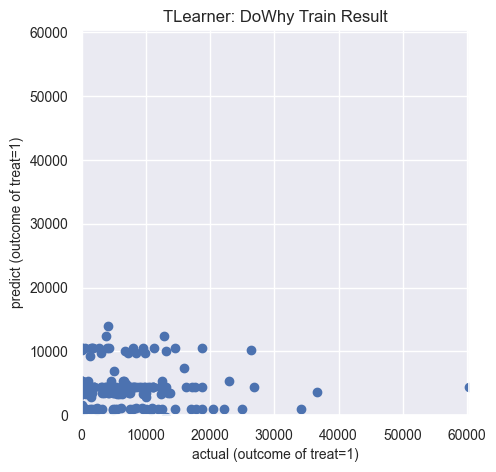

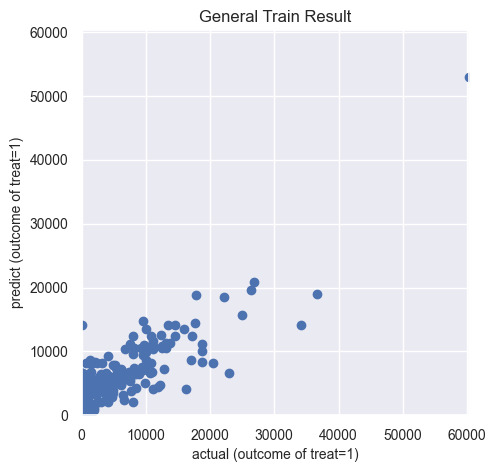

In [20]:
# データ
dataset = dataset_init.copy()
# DAGをもとにモデル定義
model= dowhy.CausalModel(data = dataset
                         , graph=causal_graph.replace("\n", " ")
                         , treatment=tr_col
                         , outcome=target_col)
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

# TLearnerで使用するモデル（LightGBM）
clf0 = LGBMRegressor(n_estimators=1000, max_depth=10, random_state=0)
clf1 = LGBMRegressor(n_estimators=1000, max_depth=10, random_state=0)
# 学習&推論
TLearner_att = model.estimate_effect(identified_estimand
                                     , method_name="backdoor.econml.metalearners.TLearner"  # EconMLが使える
                                     #, target_units=lambda df: df[tr_col]>0  # CATE(treat=1)  # CATEの条件指定可
                                     , method_params={'init_params':{'models':[clf0, clf1]}
                                                      , 'fit_params':{}
                                                     }
                                    )
# 学習させたLightGBMモデル2つ(リスト)
learner = TLearner_att.params['_estimator_object']  # EconML TLearner Object
clf0 = learner.models[0]  # treat=0のモデル
clf1 = learner.models[1]  # treat=1のモデル

df1 = dataset[dataset[tr_col]==1].reset_index(drop=True).copy()  # treat=1のサンプル
df0 = dataset[dataset[tr_col]==0].reset_index(drop=True).copy()  # treat=0のサンプル

### 実測予測プロット ###
# DoWhy経由で実施すると明らかにmodelの精度が悪い
fig=plt.figure(figsize=(5,5))
plt.scatter(df1[target_col].to_numpy(), clf1.predict(df1[exp_col].to_numpy()))
plt.xlim(0, max(df1[target_col].to_numpy().max(), clf1.predict(df1[exp_col].to_numpy()).max()))
plt.ylim(0, max(df1[target_col].to_numpy().max(), clf1.predict(df1[exp_col].to_numpy()).max()))
plt.xlabel('actual (outcome of treat=1)', fontsize=10)
plt.ylabel('predict (outcome of treat=1)', fontsize=10)
plt.title(learner.__class__.__name__+': DoWhy Train Result', fontsize=12)
plt.tick_params(labelsize=10)
plt.show()


# 普通に予測モデルを学習させると精度はいい
clf0 = LGBMRegressor(n_estimators=1000, max_depth=10, random_state=0)
clf1 = LGBMRegressor(n_estimators=1000, max_depth=10, random_state=0)
clf0.fit(df0[exp_col], df0[target_col])
clf1.fit(df1[exp_col], df1[target_col])
fig=plt.figure(figsize=(5,5))
plt.scatter(df1[target_col].to_numpy(), clf1.predict(df1[exp_col].to_numpy()))
plt.xlim(0, max(df1[target_col].to_numpy().max(), clf1.predict(df1[exp_col].to_numpy()).max()))
plt.ylim(0, max(df1[target_col].to_numpy().max(), clf1.predict(df1[exp_col].to_numpy()).max()))
plt.xlabel('actual (outcome of treat=1)', fontsize=10)
plt.ylabel('predict (outcome of treat=1)', fontsize=10)
plt.title('General Train Result', fontsize=12)
plt.tick_params(labelsize=10)
plt.show()

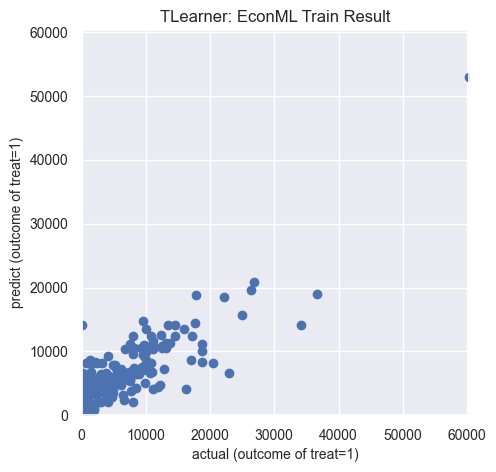

In [21]:
# データ
dataset = dataset_init.copy()
# TLearnerで使用するモデル（LightGBM）
clf0 = LGBMRegressor(n_estimators=1000, max_depth=10, random_state=0)  # treat=0のモデル
clf1 = LGBMRegressor(n_estimators=1000, max_depth=10, random_state=0)  # treat=1のモデル
est = TLearner(models=[clf0, clf1])  # EconML TLearner Object
# 学習
est.fit(dataset[target_col], dataset[tr_col], X=dataset[exp_col])

clf0 = est.models[0]  # treat=0の学習済みモデル
clf1 = est.models[1]  # treat=1の学習済みモデル

# treat=1のサンプル
df1 = dataset[dataset[tr_col]==1].reset_index(drop=True).copy()
# treat=0のサンプル
df0 = dataset[dataset[tr_col]==0].reset_index(drop=True).copy()

### 実測予測プロット ###
fig=plt.figure(figsize=(5,5))
plt.scatter(df1[target_col].to_numpy(), clf1.predict(df1[exp_col].to_numpy()))
plt.xlim(0, max(df1[target_col].to_numpy().max(), clf1.predict(df1[exp_col].to_numpy()).max()))
plt.ylim(0, max(df1[target_col].to_numpy().max(), clf1.predict(df1[exp_col].to_numpy()).max()))
plt.xlabel('actual (outcome of treat=1)', fontsize=10)
plt.ylabel('predict (outcome of treat=1)', fontsize=10)
plt.title(est.__class__.__name__+': EconML Train Result', fontsize=12)
plt.tick_params(labelsize=10)
plt.show()

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


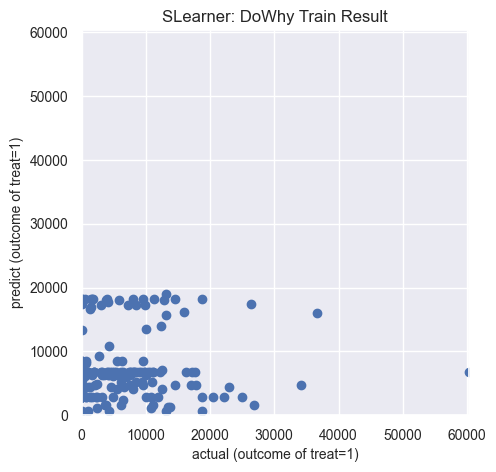

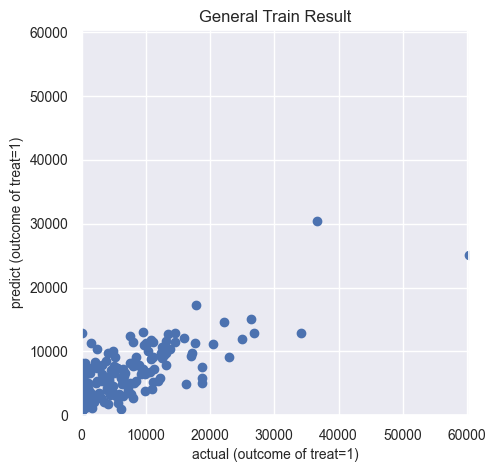

In [22]:
# データ
dataset = dataset_init.copy()
# DAGをもとにモデル定義
model= dowhy.CausalModel(data = dataset
                         , graph=causal_graph.replace("\n", " ")
                         , treatment=tr_col
                         , outcome=target_col)
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
# TLearnerで使用するモデル（LightGBM）
clf = LGBMRegressor(n_estimators=1000, max_depth=10, random_state=0)
SLearner_att = model.estimate_effect(identified_estimand
                                     , method_name="backdoor.econml.metalearners.SLearner"
                                     #, target_units=lambda df: df[tr_col]>0  # CATE(treat=1)  # CATEの条件指定可
                                     , method_params={'init_params':{'overall_model':clf}
                                                      , 'fit_params':{}
                                                     }
                                    )

learner = SLearner_att.params['_estimator_object']  # EconML TLearner Object
clf = learner.overall_model  # 学習済みモデル

tr1_ind = dataset[dataset[tr_col]==1].index  # treat=1のindex番号
tr0_ind = dataset[dataset[tr_col]==0].index  # treat=0のindex番号

### EconML SLearnerは内部でTreat変数をOneHotしているので同様に加工 ###
# treat=1用
df1 = dataset.copy()
df1.drop(columns=[target_col, tr_col], inplace=True)
df1[tr_col+'_inv'] = 0
df1[tr_col] = 1
# treat=0用
df0 = dataset.copy()
df0.drop(columns=[target_col, tr_col], inplace=True)
df0[tr_col+'_inv'] = 1
df0[tr_col] = 0

### 実測予測プロット ###
# DoWhy経由で実施すると明らかにmodelの精度が悪い
fig=plt.figure(figsize=(5,5))
plt.scatter(dataset[dataset[tr_col]==1][target_col].to_numpy(), clf.predict(df1.iloc[tr1_ind,:].to_numpy()))
plt.xlim(0, max(dataset[dataset[tr_col]==1][target_col].to_numpy().max(), clf.predict(df1.iloc[tr1_ind,:].to_numpy()).max()))
plt.ylim(0, max(dataset[dataset[tr_col]==1][target_col].to_numpy().max(), clf.predict(df1.iloc[tr1_ind,:].to_numpy()).max()))
plt.xlabel('actual (outcome of treat=1)', fontsize=10)
plt.ylabel('predict (outcome of treat=1)', fontsize=10)
plt.title(learner.__class__.__name__+': DoWhy Train Result', fontsize=12)
plt.tick_params(labelsize=10)
plt.show()


# 普通に予測モデルを学習させると精度はいい
clf = LGBMRegressor(n_estimators=1000, max_depth=10, random_state=0)
clf.fit(dataset[exp_col+[tr_col]], dataset[target_col])

fig=plt.figure(figsize=(5,5))
plt.scatter(dataset[dataset[tr_col]==1][target_col].to_numpy()
            , clf.predict(dataset[dataset[tr_col]==1][exp_col+[tr_col]].to_numpy()))
plt.xlim(0, max(dataset[dataset[tr_col]==1][target_col].to_numpy().max(), clf.predict(dataset[dataset[tr_col]==1][exp_col+[tr_col]].to_numpy()).max()))
plt.ylim(0, max(dataset[dataset[tr_col]==1][target_col].to_numpy().max(), clf.predict(dataset[dataset[tr_col]==1][exp_col+[tr_col]].to_numpy()).max()))
plt.xlabel('actual (outcome of treat=1)', fontsize=10)
plt.ylabel('predict (outcome of treat=1)', fontsize=10)
plt.title('General Train Result', fontsize=12)
plt.tick_params(labelsize=10)
plt.show()

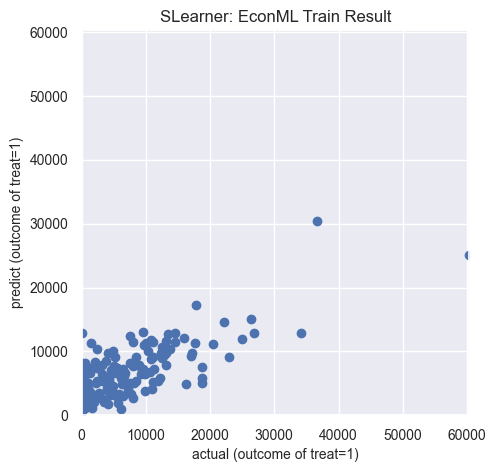

In [23]:
# データ
dataset = dataset_init.copy()
# SLearnerで使用するモデル（LightGBM）
clf = LGBMRegressor(n_estimators=1000, max_depth=10, random_state=0)  # モデル
est = SLearner(overall_model=clf)  # EconML SLearner Object
# 学習
est.fit(dataset[target_col], dataset[tr_col], X=dataset[exp_col])

clf = est.overall_model  # 学習済みモデル

tr1_ind = dataset[dataset[tr_col]==1].index  # treat=1のindex番号
tr0_ind = dataset[dataset[tr_col]==0].index  # treat=0のindex番号

### EconML SLearnerは内部でTreat変数をOneHotしているので同様に加工 ###
# treat=1用
df1 = dataset.copy()
df1.drop(columns=[target_col, tr_col], inplace=True)
df1[tr_col+'_inv'] = 0
df1[tr_col] = 1
# treat=0用
df0 = dataset.copy()
df0.drop(columns=[target_col, tr_col], inplace=True)
df0[tr_col+'_inv'] = 1
df0[tr_col] = 0

### 実測予測プロット ###
fig=plt.figure(figsize=(5,5))
plt.scatter(dataset[dataset[tr_col]==1][target_col].to_numpy(), clf.predict(df1.iloc[tr1_ind,:].to_numpy()))
plt.xlim(0, max(dataset[dataset[tr_col]==1][target_col].to_numpy().max(), clf.predict(df1.iloc[tr1_ind,:].to_numpy()).max()))
plt.ylim(0, max(dataset[dataset[tr_col]==1][target_col].to_numpy().max(), clf.predict(df1.iloc[tr1_ind,:].to_numpy()).max()))
plt.xlabel('actual (outcome of treat=1)', fontsize=10)
plt.ylabel('predict (outcome of treat=1)', fontsize=10)
plt.title(est.__class__.__name__+': EconML Train Result', fontsize=12)
plt.tick_params(labelsize=10)
plt.show()